# Forecasting Models

In this notebook all relevant models, namley Dense, LSTM, CNN, Transformer and MoEs (gating: soft, top_1, top_k) are build, compiled, fitted, evaluated, and plotted. Therefore, the notebook ist structured into: 
- Data Handling
- Model Building

In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf
#from keras import layers, models

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

### Data Handling
- **Get Data**: Load data to dataframe from User5. Data includes Date, temp, hour and Electricity consumption
- **Train, Validation and Test datasets**: Split Data into train, validation and test datasets
- **Normalize Data**: Normalize each feature of the the different datasets
- **Sequencing**: Take the 3 datasets and split them into sequences of length=sequence_length, then split the sequence into  X (features) and Y (labels)

In [2]:
#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

#Select only 1 User for testing
df = df[['User2', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User2_lag_24hrs']]
df.head(3)

,User2,temp,rhum,wspd,PC1,hour sin,hour cos,User2_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.215,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.102
2012-07-08 01:00:00,0.136,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.116
2012-07-08 02:00:00,0.187,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.133


In [3]:
#Train, Validation and Test datasets
sequence_length = 49
batch_size = 16
num_features = df.shape[1]

dh = Datahandler()

#Create Train, Validation and Test datasets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Min max sclaing
train_df = dh.min_max_scaling(train_df)
val_df = dh.min_max_scaling(val_df)
test_df = dh.min_max_scaling(test_df)

# Sequencing
train_sequences = dh.create_sequences(train_df, sequence_length)
val_sequences = dh.create_sequences(val_df, sequence_length)
test_sequences = dh.create_sequences(test_df, sequence_length)

#Split into feature and label
X_train, y_train = dh.prepare_data(train_sequences, batch_size)
X_val, y_val = dh.prepare_data(val_sequences, batch_size)
X_test, y_test = dh.prepare_data(test_sequences, batch_size)

### Model Building
Build and test different model architecture

In [4]:
#Hyperparameters

# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
callbacks=[early_stopping, timing_callback, custom_callback]

#MoE
num_experts = 5
sequenze_length = 48
expert_capacity = sequenze_length*batch_size // num_experts #= 48 / 10 = 4

top_k = 3
dense_1_units = 32
expert_hidden_units = 16
expert_output_units = 32
dense_2_units = 32
dense_3_units= 8

In [5]:
tuning_rounds = 2
results = pd.DataFrame(columns=['avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])
        
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    softgated_moe_model = m1.build_softgated_moe_model(X_train, batch_size, horizon, dense_1_units, num_experts, expert_hidden_units, expert_output_units, dense_2_units, m1)
    moe_model_history, moe_results, moe_summary  = mh.compile_fit_evaluate_model(softgated_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
    results = pd.concat([results, moe_summary])

Evaluation round:  1
Epoch 1/100
372/372 [==============================] - 2s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - mean_absolute_percentage_error: 14420432.0000 - mean_absolute_error: 0.0674 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240 - val_mean_absolute_percentage_error: 60140.9961 - val_mean_absolute_error: 0.0655
Epoch 2/100
372/372 [==============================] - 1s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - mean_absolute_percentage_error: 7814474.5000 - mean_absolute_error: 0.0500 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230 - val_mean_absolute_percentage_error: 58800.5547 - val_mean_absolute_error: 0.0749
Epoch 3/100
372/372 [==============================] - 1s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - mean_absolute_percentage_error: 7023856.0000 - mean_absolute_error: 0.0484 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264 - val_mean_absolute_percentage_error: 42834.7539 - val_mean_ab

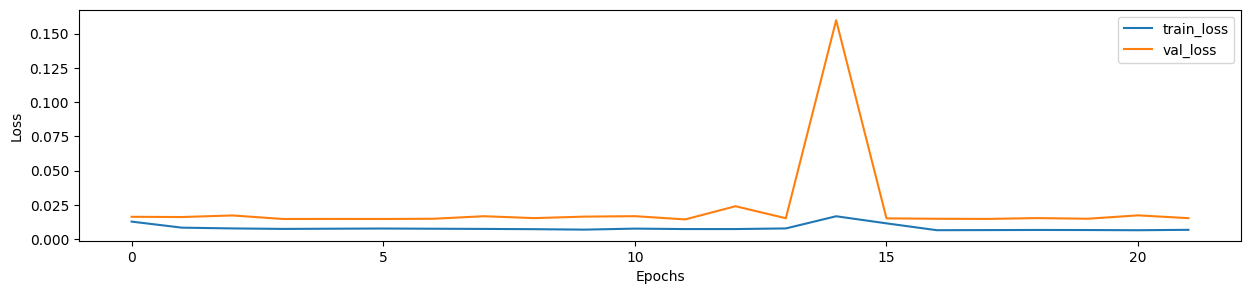

50/50 [==============================] - 0s 1ms/step


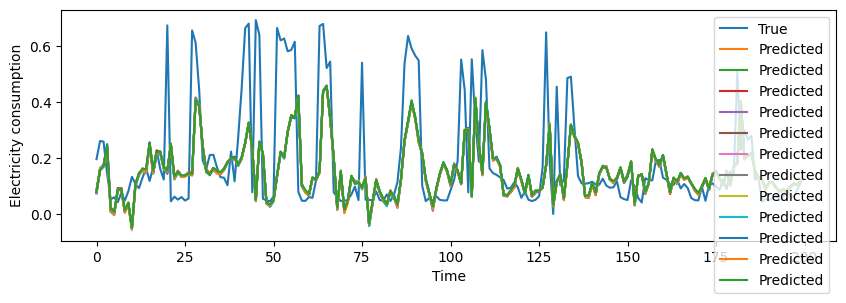

,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,20,0.917823,18.505243,0.132170,0.081226
0,22,0.908868,20.148508,0.132227,0.077138


In [6]:
mh.plot_model_predictions(softgated_moe_model, moe_model_history, y_test, X_test, batch_size, plt_length=200)
results

Epoch 1/100
372/372 [==============================] - 2s 2ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - mean_absolute_percentage_error: 14681392.0000 - mean_absolute_error: 0.0700 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1243 - val_mean_absolute_percentage_error: 65953.4297 - val_mean_absolute_error: 0.0749
Epoch 2/100
372/372 [==============================] - 1s 2ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - mean_absolute_percentage_error: 8544714.0000 - mean_absolute_error: 0.0504 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233 - val_mean_absolute_percentage_error: 44477.2656 - val_mean_absolute_error: 0.0594
Epoch 3/100
372/372 [==============================] - 1s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - mean_absolute_percentage_error: 7690927.5000 - mean_absolute_error: 0.0484 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229 - val_mean_absolute_percentage_error: 85177.2188 - val_mean_absolute_error: 0.0758


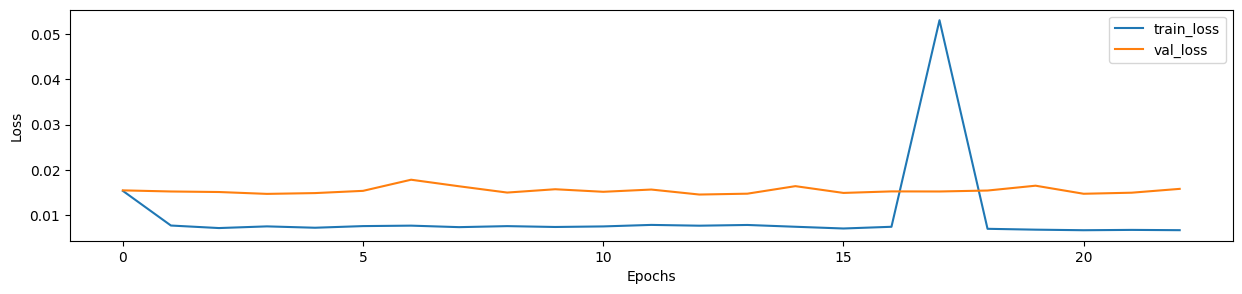

50/50 [==============================] - 0s 919us/step


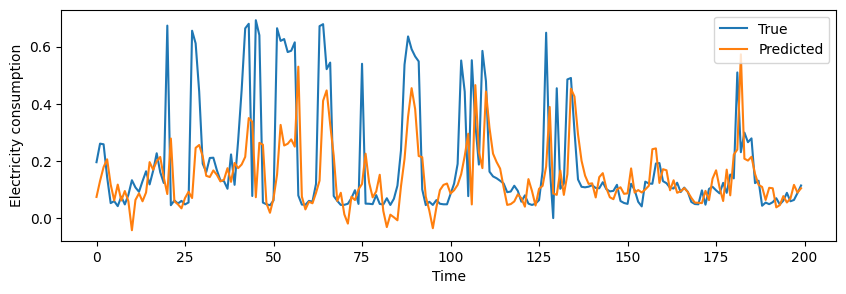

In [5]:
#Softmax Gating

softgated_moe_model = m1.build_softgated_moe_model(X_train, batch_size, horizon, dense_1_units, num_experts, expert_hidden_units, expert_output_units, dense_2_units, m1)
moe_model_history, moe_results, moe_summary  = mh.compile_fit_evaluate_model(softgated_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
mh.plot_model_predictions(softgated_moe_model, moe_model_history, y_test, X_test, batch_size, plt_length=200)

In [7]:
moe_summary

,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,23,0.81827,18.967256,0.134921,0.076143


In [6]:
#top_1_moe_model

#top1_moe_model = m1.build_top1_moe_model(X_train, batch_size, horizon, sequenze_length, num_experts, expert_capacity, expert_dim, dense_1_units, dense_2_units, dense_3_units, m1)
#history_dense_model  = mh.compile_fit_evaluate_model(top1_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
#mh.plot_model_predictions(top1_moe_model, history_dense_model, y_test, X_test, batch_size, plt_length=200)

In [9]:
#top_k_moe_model

#topk_moe_model = m1.build_topk_moe_model(X_train, batch_size, horizon, dense_1_units, num_experts, top_k, expert_hidden_units, expert_output_units, dense_2_units, m1)
#moe_model_history  = mh.compile_fit_evaluate_model(topk_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
#mh.plot_model_predictions(topk_moe_model, moe_model_history, y_test, X_test, batch_size, plt_length=200)

In [7]:
"""
#Build Deep Learning Models
dense_model = m1.build_dense_model(X_train, horizon, units=64)
lstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)
cnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)
bilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=32)
probability_model = m1.build_probability_model(X_train, horizon, units=128)
transformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=2, key_dim=4)

#Compile, fit, evaluate deep learning models
history_dense_model  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_lstm_model  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_cnn_model  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_bilstm_model  = mh.compile_fit_evaluate_model(bilstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_probability_model  = mh.compile_fit_evaluate_model(probability_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_transformer_model  = mh.compile_fit_evaluate_model(transformer_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)


#Plot deep learning models
mh.plot_model_predictions(dense_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(lstm_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(cnn_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(bilstm_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(dense_model, history_probability_model, y_test, X_test, batch_size)
mh.plot_model_predictions(dense_model, history_transformer_model, y_test, X_test, batch_size)


#Statistical models
svm_model = m1.build_svm_model(kernel='linear')
elasticnet_regression_model = m1.build_elasticnet_regression_model(alpha=0.0001, l1_ratio=0.5)
decisiontree_model = m1.build_decisiontree_model()
randomforrest_model = m1.build_randomforrest_model(n_estimators=10)
k_neighbors_model = m1.build_k_neighbors_model(n_neighbors=5)


mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, decisiontree_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, svm_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, elasticnet_regression_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, randomforrest_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, k_neighbors_model)
"""

Transformer:  (None, 48, 32)
Transformer:  (None, 48, 1)


"\n#Build Deep Learning Models\ndense_model = m1.build_dense_model(X_train, horizon, units=64)\nlstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)\ncnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)\nbilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=32)\nprobability_model = m1.build_probability_model(X_train, horizon, units=128)\ntransformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=2, key_dim=4)\n\n#Compile, fit, evaluate deep learning models\nhistory_dense_model  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_lstm_model  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_cnn_model  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val